In [ ]:
#collapse

# setting things for pretty visualization

from rich import print
from pyannote.core import notebook, Segment
SAMPLE_EXTENT = Segment(0, 30)
notebook.crop = SAMPLE_EXTENT

SAMPLE_CHUNK = Segment(15, 20)
SAMPLE_URI = "sample"
SAMPLE_WAV = f"{SAMPLE_URI}.wav"
SAMPLE_REF = f"{SAMPLE_URI}.rttm"

# One speaker segmentation model to rule them all

In this blog post, I talk about pyannote.audio [pretrained speaker segmentation model](https://hf.co/pyannote/segmentation), which happens to be one of the [most popular audio model](https://huggingface.co/models?other=audio) available on 🤗 Huggingface model hub. 

In [ ]:
from pyannote.audio import Model
model = Model.from_pretrained("pyannote/segmentation")

## What does `pyannote/segmentation` do?

Every `pyannote.audio` model has a `specifications` attribute that tells us a bit more about itself:

In [ ]:
print(model.specifications)

Specifications(
    problem=<Problem.MULTI_LABEL_CLASSIFICATION: 2>,
    resolution=<Resolution.FRAME: 1>,
    duration=5.0,
    warm_up=(0.0, 0.0),
    classes=['speaker#1', 'speaker#2', 'speaker#3'],
    permutation_invariant=True
)

These specifications tell us the following about `pyannote/segmentation`:

* it ingests audio chunks of 5 seconds `duration`
* it addresses a multi-label classification `problem`...
* ... whose possible `classes` are chosen among `speaker#1`, `speaker#2`, and `speaker#3` ...
* ... and are `permutation_invariant` (more about that below)

We also learn that its output temporal `resolution` is the frame (_i.e._ it outputs a sequence of frame-wise decisions rather than just one decision for the whole chunk). The actual temporal resolution can be obtained through the magic `introspection` attribute (approximately 17ms for `pyannote/segmentation`):

In [ ]:
model.introspection.frames.step

0.016875

## OK, but what does `pyannote/segmentation` really do? 

To answer this question, let us consider the audio recording of a 30s conversation between two speakers (the blue one and the red one):

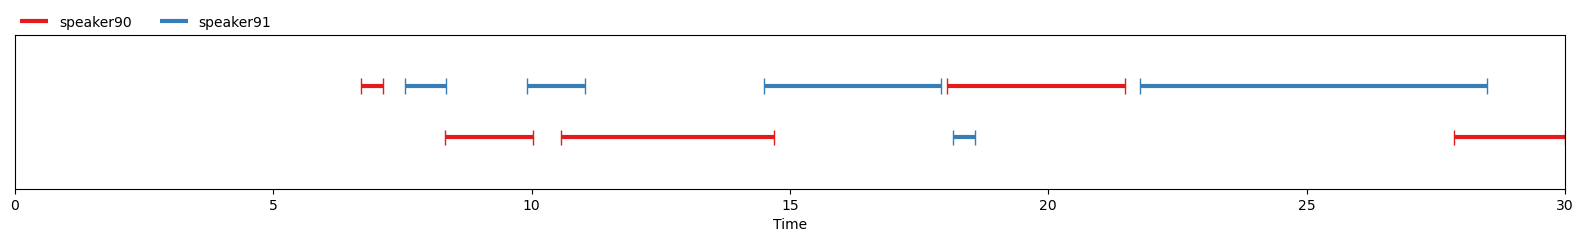

In [ ]:
#collapse

from pyannote.database.util import load_rttm
reference = load_rttm(SAMPLE_REF)[SAMPLE_URI]
reference

In [ ]:
#collapse 

from IPython.display import Audio as AudioPlayer
AudioPlayer(SAMPLE_WAV)

Let's apply the model on this 5s excerpt of the conversation:

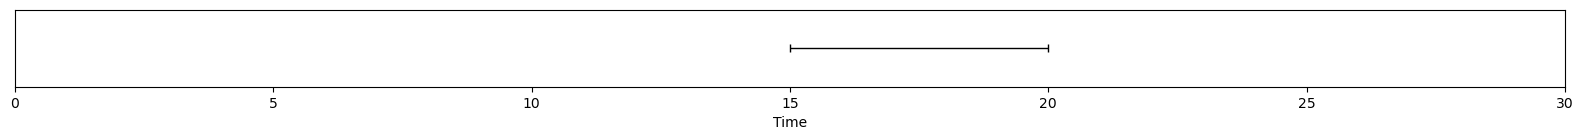

In [ ]:
#collapse 

SAMPLE_CHUNK

In [ ]:
from pyannote.audio import Audio
audio_reader = Audio(sample_rate=model.hparams.sample_rate)
waveform, sample_rate = audio_reader.crop(SAMPLE_WAV, SAMPLE_CHUNK)

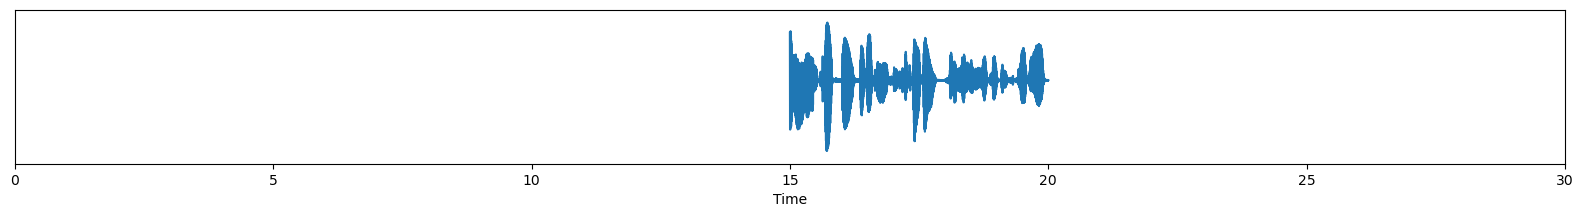

In [ ]:
#collapse 

import numpy as np
from pyannote.core import SlidingWindowFeature, SlidingWindow
_waveform, sample_rate = Audio()(SAMPLE_WAV)
_waveform = _waveform.numpy().T
_waveform[:round(SAMPLE_CHUNK.start * sample_rate)] = np.NAN
_waveform[round(SAMPLE_CHUNK.end * sample_rate):] = np.NAN
SlidingWindowFeature(_waveform, SlidingWindow(1./sample_rate, 1./sample_rate))

In [ ]:
output = model(waveform)

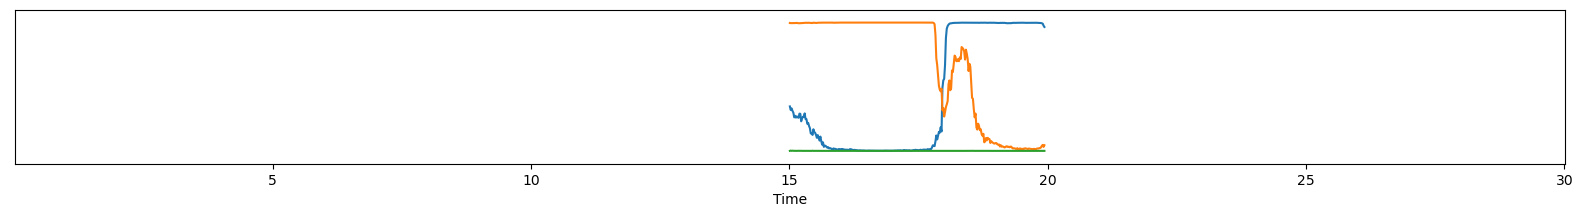

In [ ]:
#collapse 
_output = output.detach()[0].numpy()
shifted_frames = SlidingWindow(start=SAMPLE_CHUNK.start, 
                       duration=model.introspection.frames.duration, 
                       step=model.introspection.frames.step)
_output = SlidingWindowFeature(_output, shifted_frames)
_output

The model has accurately detected that two speakers are active (the orange one and the blue one) in this 5s chunk, and that they are partially overlapping around t=18s. The third speaker probability (in green) is close to zero for the whole five seconds.

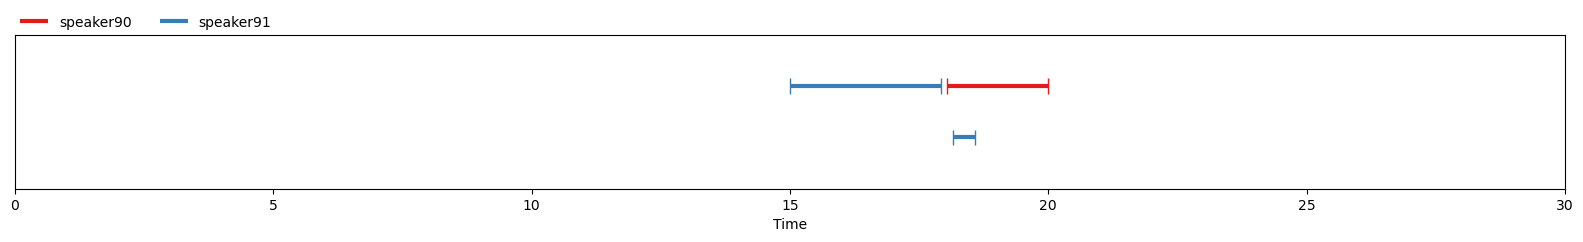

In [ ]:
#collapse 
reference.crop(SAMPLE_CHUNK)

`pyannote.audio` provides a convenient `Inference` class to apply the model using a 5s sliding window on the whole file:

In [ ]:
from pyannote.audio import Inference
inference = Inference(model, duration=5.0, step=2.5)
output = inference(SAMPLE_WAV)

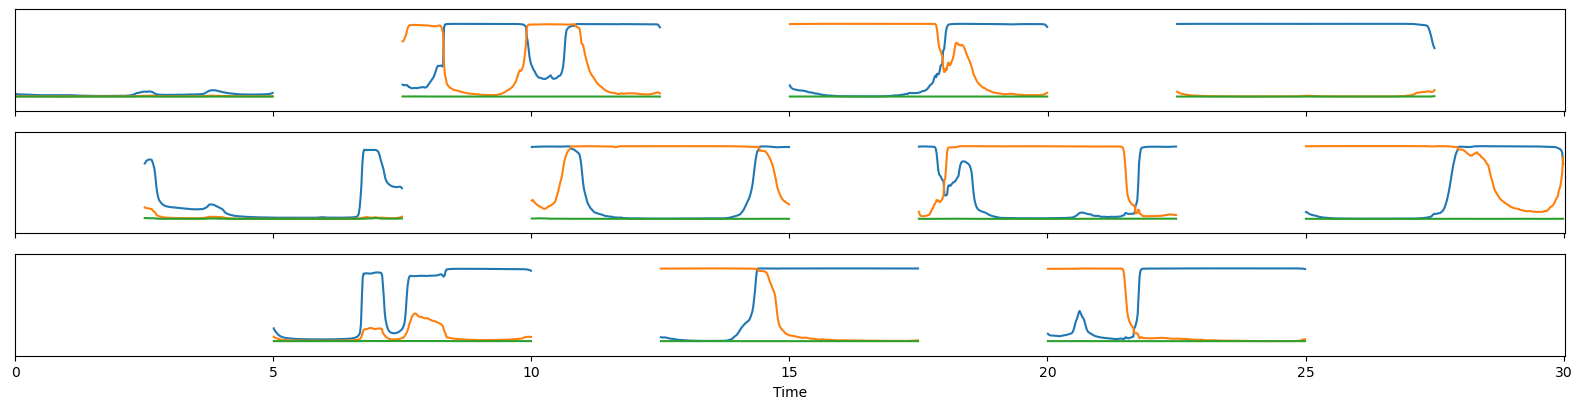

In [ ]:
#collapse
output

In [ ]:
output.data.shape

(11, 293, 3)

In [ ]:
BATCH_AXIS = 0
TIME_AXIS = 1
SPEAKER_AXIS = 2

For each of the 11 positions of the 5s window, the model outputs a 3-dimensional vector every 16ms (293 frames for 5 seconds), corresponding to the probabilities that each of (up to) 3 speakers is active.   

## "He who can do more can do less"

This model has more than one string to its bow and can prove useful for lots of speaker-related tasks such as: 
* voice activity detection
* overlapped speech detection
* instantaneous speaker counting
* speaker change detection

### Voice activity detection (VAD)

Voice activity detection is the task of detecting speech regions in a given audio stream or recording.  
This can be achieved by postprocessing the output of the model using the maximum over the _speaker_ axis for each frame.

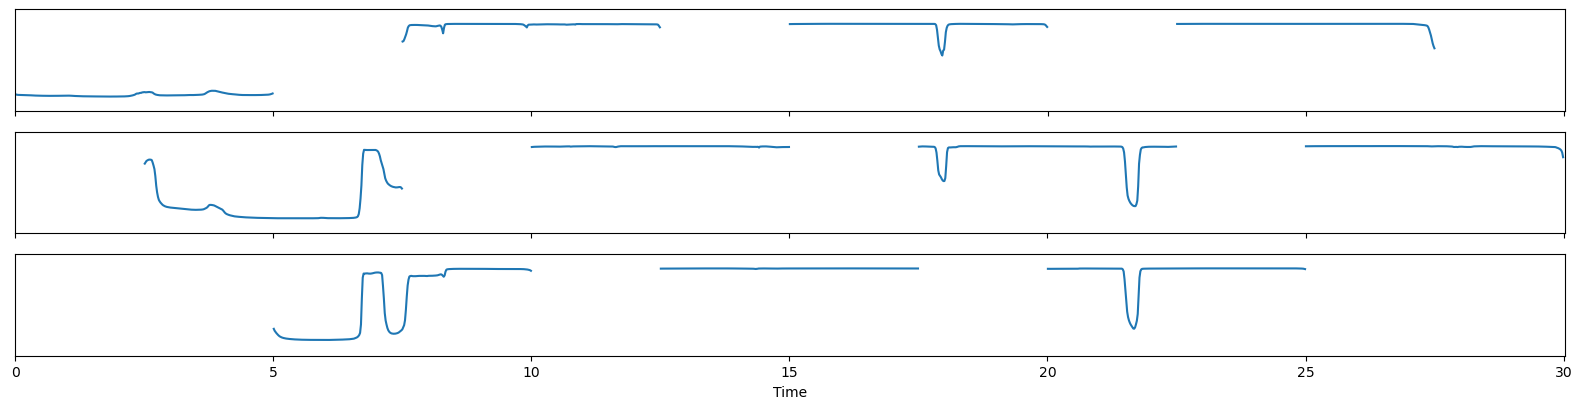

In [ ]:
to_vad = lambda o: np.max(o, axis=SPEAKER_AXIS, keepdims=True)
to_vad(output)

The `Inference` class has a built-in mechanism to apply this transformation automatically on each window and aggregate the result using _overlap-add_. This is achieved by passing the above `to_vad` function via the `pre_aggregation_hook` parameter:

In [ ]:
vad = Inference("pyannote/segmentation", pre_aggregation_hook=to_vad)
vad_prob = vad(SAMPLE_WAV)

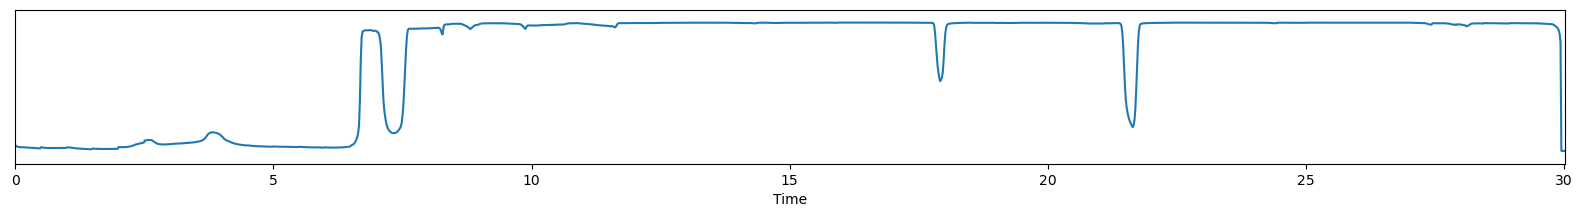

In [ ]:
#collapse
vad_prob.labels = ['SPEECH']
vad_prob

`Binarize` utility class can eventually convert this frame-based probabiliy to the time domain:

In [ ]:
from pyannote.audio.utils.signal import Binarize
binarize = Binarize(onset=0.5)
speech = binarize(vad_prob)

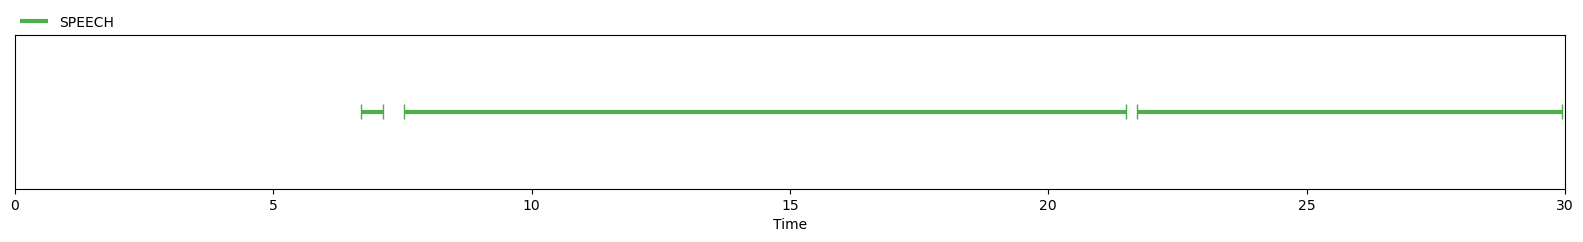

In [ ]:
#collapse
speech

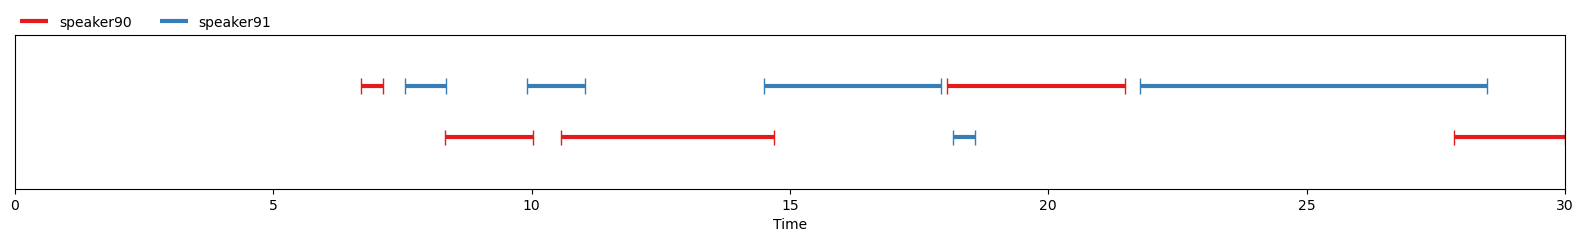

In [ ]:
#collapse
reference

### Overlapped speech detection (OSD)

Overlapped speech detection is the task of detecting regions where at least two speakers are speaking at the same time.
This can be achieved by postprocessing the output of the model using the **second** maximum over the _speaker_ axis for each frame.


In [ ]:
to_osd = lambda o: np.partition(o, -2, axis=SPEAKER_AXIS)[:, :, -2, np.newaxis]
osd = Inference("pyannote/segmentation", pre_aggregation_hook=to_osd)
osd_prob = osd(SAMPLE_WAV)

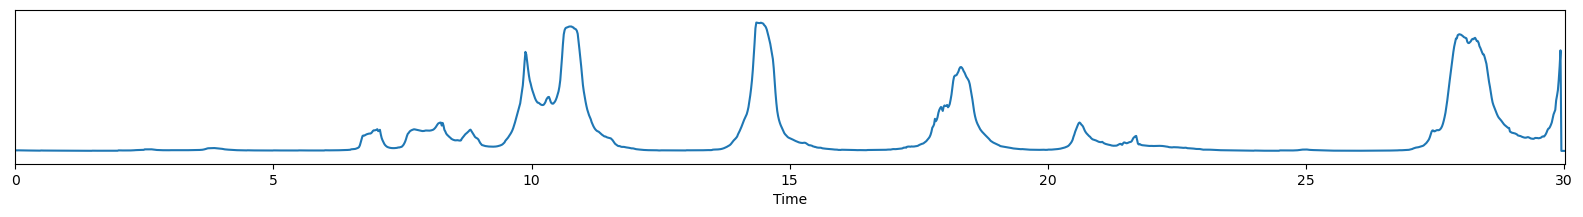

In [ ]:
#collapse
osd_prob.labels = ['OVERLAP']
osd_prob

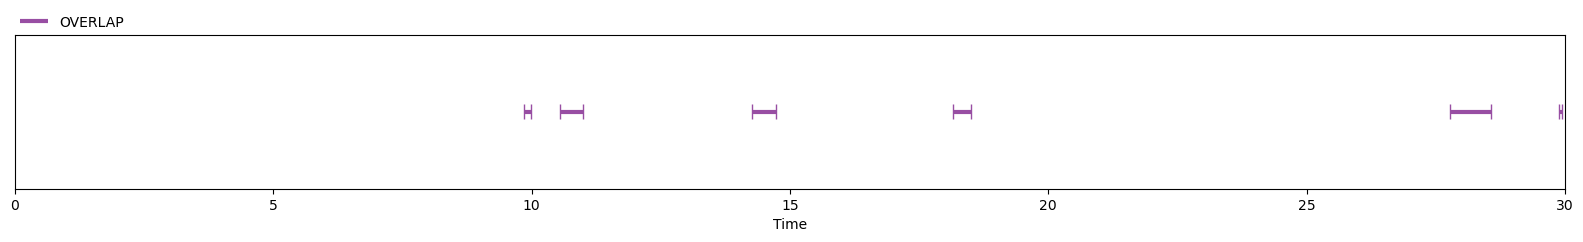

In [ ]:
binarize(osd_prob)

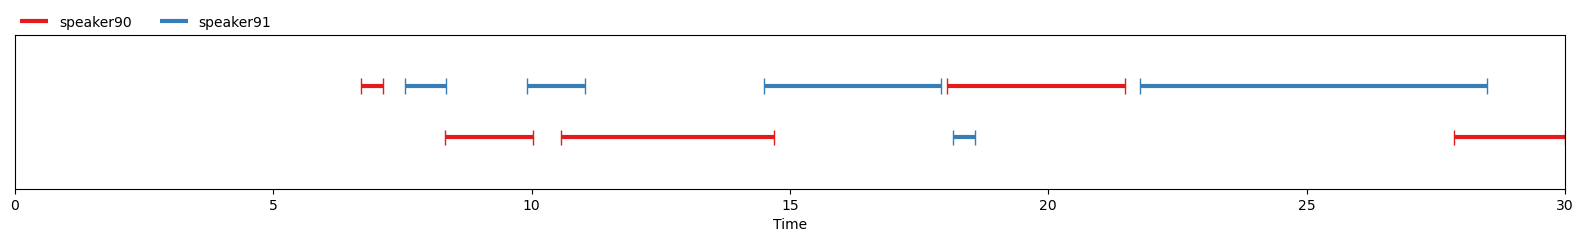

In [ ]:
#collapse
reference

### Instantaneous speaker counting (CNT)

Instantaneous speaker counting is a generalization of voice activity and overlapped speech detection that aims at returning the number of simultaneous speakers at each frame. This can be achieved by summing the output of the model over the _speaker_ axis for each frame:

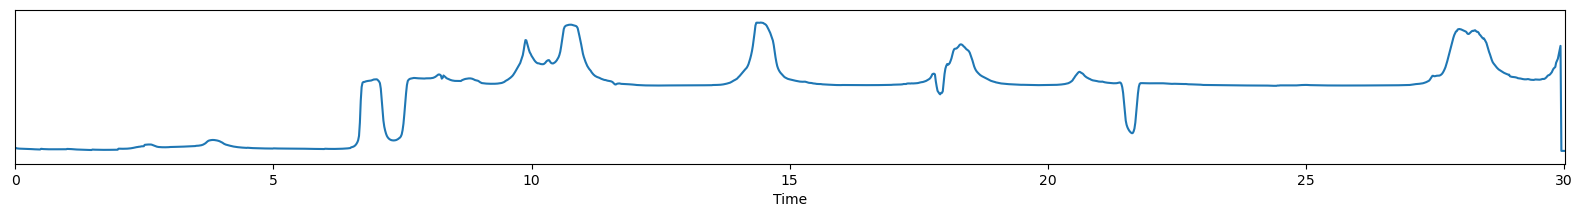

In [ ]:
to_cnt = lambda probability: np.sum(probability, axis=SPEAKER_AXIS, keepdims=True)
cnt = Inference("pyannote/segmentation", pre_aggregation_hook=to_cnt)
cnt(SAMPLE_WAV)

### Speaker change detection (SCD)

Speaker change detection is the task of detecting speaker change points in a given audio stream or recording.  It can be achieved by taking the absolute value of the first derivative over the *time* axis, and take the maximum value over the *speaker* axis:

In [ ]:
to_scd = lambda probability: np.max(
    np.abs(np.diff(probability, n=1, axis=TIME_AXIS)), 
    axis=SPEAKER_AXIS, keepdims=True)
scd = Inference("pyannote/segmentation", pre_aggregation_hook=to_scd)
scd_prob = scd(SAMPLE_WAV)

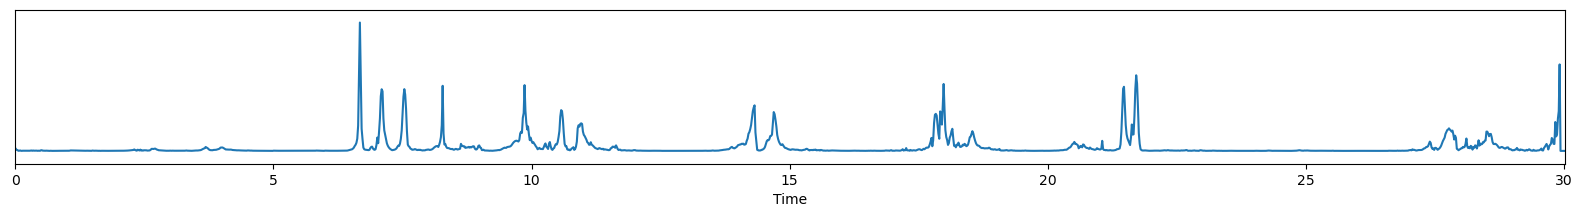

In [ ]:
#collapse
scd_prob.labels = ['SPEAKER_CHANGE']
scd_prob

Using a combination of `Peak` utility class (to detect peaks in the above curve) and voice activity detection output, we can obtain a decent segmentation into speaker turns:

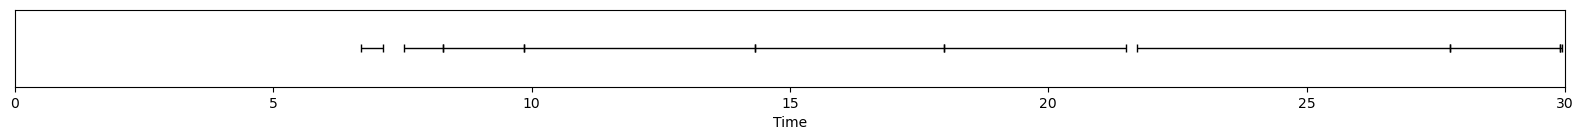

In [ ]:
from pyannote.audio.utils.signal import Peak
peak = Peak(alpha=0.05)
peak(scd_prob).crop(speech.get_timeline())

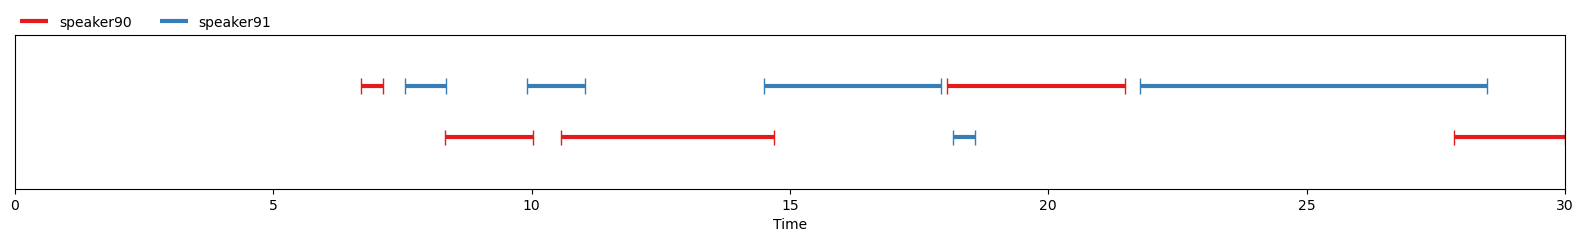

In [ ]:
#collapse
reference

### What  `pyannote/segmentation` CANNOT do 

Now, let's take a few steps back and have a closer look at the raw output of the model.

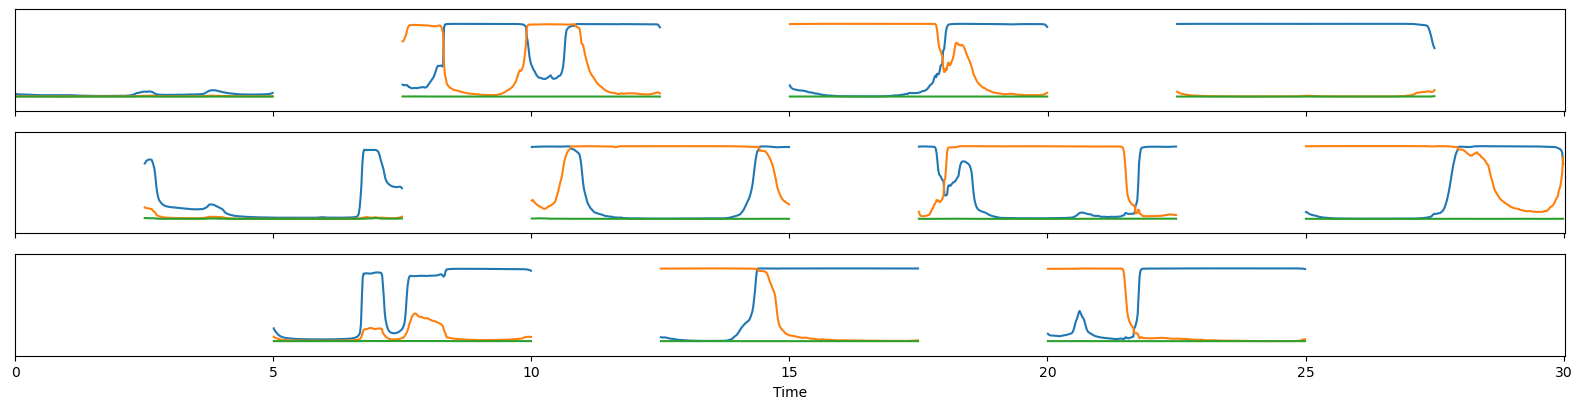

In [ ]:
#collapse
output

Did you notice that the blue and orange speakers have been swapped between overlapping windows `[15s, 20s]` and `[17.5s, 22.5s]`?

This is a (deliberate) side effect of the permutation-invariant training process using when training the model.  
The model is trained to discriminate speakers locally (i.e. within each window) but does not care about their global identity (i.e. at conversation scale). Have a look at [this paper](http://arxiv.org/abs/2104.04045) to learn more about this permutation-invariant training thing.

That means that this kind of model does not actually perform speaker diarization out of the box.  
Luckily, `pyannote.audio` has got you covered! `pyannote/speaker-diarization` [pretrained pipeline](https://hf.co/pyannote/speaker-diarization) uses `pyannote/segmentation` internally and combines it with speaker embeddings to deal with this permutation problem globally.

## That's all folks! 

For [technical questions](https://github.com/pyannote/pyannote-audio/discussions) and [bug reports](https://github.com/pyannote/pyannote-audio/issues), please check [pyannote.audio](https://github.com/pyannote/pyannote-audio) Github repository.

[I](https://herve.niderb.fr) also offer scientific consulting services around speaker diarization (and speech processing in general), please contact [me](mailto:herve@niderb.fr) if you think this type of technology might help your business/startup!